In [1]:
import random
import pandas as pd
from math import log
import numpy as np

The functions for entropy and information gain are used to find where to split the data to get the highest info gain value.
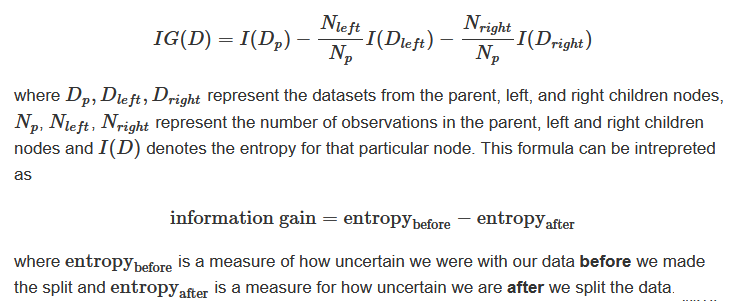

In [2]:
def entropy(v):
  sum_pi_log_pi = 0
  if np.unique(v).size == 1:
    return 0
  for i in np.unique(v):
    p_i = ((v==i).sum()) / v.size #probability of ith unique
    log_p_i = log(p_i, np.unique(v).size) #base of log correspondence
    sum_pi_log_pi += p_i*log_p_i
  return - sum_pi_log_pi

In [3]:
def information_gain(left_child, right_child):
    parent = left_child + right_child
    p_parent = parent.count(1) / len(parent) if len(parent) > 0 else 0
    p_left = left_child.count(1) / len(left_child) if len(left_child) > 0 else 0
    p_right = right_child.count(1) / len(right_child) if len(right_child) > 0 else 0
    IG_p = entropy(p_parent)
    IG_l = entropy(p_left)
    IG_r = entropy(p_right)
    return IG_p - len(left_child) / len(parent) * IG_l - len(right_child) / len(parent) * IG_r

The **draw_bootstrap(X_train, y_train):** function takes a X_train and y_train and creates an array. This function also returns OOB samples which are used to evaluate the performance of the decision tree later on.

In [4]:
def draw_bootstrap(X_train, y_train):
  bootstrap_indices = list(np.random.choice(range(len(X_train)), len(X_train), replace = True))
  oob_indices = [i for i in range(len(X_train)) if i not in bootstrap_indices]
  X_bootstrap = X_train.iloc[bootstrap_indices].values
  y_bootstrap = y_train[bootstrap_indices]
  X_oob = X_train.iloc[oob_indices].values
  y_oob = y_train[oob_indices]
  return X_bootstrap, y_bootstrap, X_oob, y_oob

In [5]:
def oob_score(tree, X_test, y_test):
    mis_label = 0
    for i in range(len(X_test)):
        pred = predict_tree(tree, X_test[i])
        if pred != y_test[i]:
            mis_label += 1
    return mis_label / len(X_test)

The **def find_split_points** function will select features at random and iterate through its values to compute the information gain. It will return a dict representing a node in the tree.
A node will consist of:

(int) the feature index

(int) the value to split at

(dictionary) left child node

(dictionary) right child node


In [6]:
def find_split_point(X_bootstrap, y_bootstrap, max_features):
    feature_ls = list()
    num_features = len(X_bootstrap[0])

    while len(feature_ls) <= max_features:
      feature_idx = random.sample(range(num_features), 1)
    if feature_idx not in feature_ls:
        feature_ls.extend(feature_idx)

    best_info_gain = -999
    node = None
    for feature_idx in feature_ls:
      for split_point in X_bootstrap[:,feature_idx]:
          left_child = {'X_bootstrap': [], 'y_bootstrap': []}
          right_child = {'X_bootstrap': [], 'y_bootstrap': []}

          # split children for continuous variables
          if type(split_point) in [int, float]:
              for i, value in enumerate(X_bootstrap[:,feature_idx]):
                  if value <= split_point:
                      left_child['X_bootstrap'].append(X_bootstrap[i])
                      left_child['y_bootstrap'].append(y_bootstrap[i])
                  else:
                      right_child['X_bootstrap'].append(X_bootstrap[i])
                      right_child['y_bootstrap'].append(y_bootstrap[i])
          # split children for categoric variables
          else:
              for i, value in enumerate(X_bootstrap[:,feature_idx]):
                  if value == split_point:
                      left_child['X_bootstrap'].append(X_bootstrap[i])
                      left_child['y_bootstrap'].append(y_bootstrap[i])
                  else:
                      right_child['X_bootstrap'].append(X_bootstrap[i])
                      right_child['y_bootstrap'].append(y_bootstrap[i])

          split_info_gain = information_gain(left_child['y_bootstrap'], right_child['y_bootstrap'])
          if split_info_gain > best_info_gain:
              best_info_gain = split_info_gain
              left_child['X_bootstrap'] = np.array(left_child['X_bootstrap'])
              right_child['X_bootstrap'] = np.array(right_child['X_bootstrap'])
              node = {'information_gain': split_info_gain,
                      'left_child': left_child,
                      'right_child': right_child,
                      'split_point': split_point,
                      'feature_idx': feature_idx}


    return node

The **def terminal_node(node)** and **def split_node** functions create terminal nodes (the bottom nodes in the decision tree)

In [7]:
def terminal_node(node):
    y_bootstrap = node['y_bootstrap']
    pred = max(y_bootstrap, key = y_bootstrap.count)
    return pred

In [8]:
def split_node(node, max_features, min_samples_split, max_depth, depth):
    left_child = node['left_child']
    right_child = node['right_child']

    del(node['left_child'])
    del(node['right_child'])

    if len(left_child['y_bootstrap']) == 0 or len(right_child['y_bootstrap']) == 0:
        empty_child = {'y_bootstrap': left_child['y_bootstrap'] + right_child['y_bootstrap']}
        node['left_split'] = terminal_node(empty_child)
        node['right_split'] = terminal_node(empty_child)
        return

    if depth >= max_depth:
        node['left_split'] = terminal_node(left_child)
        node['right_split'] = terminal_node(right_child)
        return node

    if len(left_child['X_bootstrap']) <= min_samples_split:
        node['left_split'] = node['right_split'] = terminal_node(left_child)
    else:
        node['left_split'] = find_split_point(left_child['X_bootstrap'], left_child['y_bootstrap'], max_features)
        split_node(node['left_split'], max_depth, min_samples_split, max_depth, depth + 1)
    if len(right_child['X_bootstrap']) <= min_samples_split:
        node['right_split'] = node['left_split'] = terminal_node(right_child)
    else:
        node['right_split'] = find_split_point(right_child['X_bootstrap'], right_child['y_bootstrap'], max_features)
        split_node(node['right_split'], max_features, min_samples_split, max_depth, depth + 1)

The **def build_tree()** function will create a root node and split the node. 

The **def random_forest()** function continues to split the nodes until each branch has a terminal node, and returns the decision tree.

In [9]:
def build_tree(X_bootstrap, y_bootstrap, max_depth, min_samples_split, max_features):
    root_node = find_split_point(X_bootstrap, y_bootstrap, max_features)
    split_node(root_node, max_features, min_samples_split, max_depth, 1)
    return root_node

In [10]:
def random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split):
    tree_ls = list()
    oob_ls = list()
    for i in range(n_estimators):
        X_bootstrap, y_bootstrap, X_oob, y_oob = draw_bootstrap(X_train, y_train)
        tree = build_tree(X_bootstrap, y_bootstrap, max_features, max_depth, min_samples_split)
        tree_ls.append(tree)
        oob_error = oob_score(tree, X_oob, y_oob)
        oob_ls.append(oob_error)
    print("OOB estimate: {:.2f}".format(np.mean(oob_ls)))
    return tree_ls

In [11]:
# Predicts the classification from an input vector (takes X features data as input)
def predict_tree(tree, X_test):
    feature_idx = tree['feature_idx']

    if X_test[feature_idx] <= tree['split_point']:
        if type(tree['left_split']) == dict:
            return predict_tree(tree['left_split'], X_test)
        else:
            value = tree['left_split']
            return value
    else:
        if type(tree['right_split']) == dict:
            return predict_tree(tree['right_split'], X_test)
        else:
            return tree['right_split']

In [12]:
# Uses all the decision trees in the ensemble to make a prediction on an input X vector. 
# Whichever class gets predicted the most is the final prediction for the model.
def predict_rf(tree_ls, X_test):
    pred_ls = list()
    for i in range(len(X_test)):
        ensemble_preds = [predict_tree(tree, X_test.values[i]) for tree in tree_ls]
        final_pred = max(ensemble_preds, key = ensemble_preds.count)
        pred_ls.append(final_pred)
    return np.array(pred_ls)

In [13]:
# Test dataset 'df' gets split into a training and test set.
df = pd.DataFrame(data=[[2.50, 2.05, 0],[1.2,5.92,1],[2.5,4.92,1], [4.00,4.92,0],[3.52,1.48,0], [2.86,4.21,1]], columns=['x1', 'x2', 'Target'])


nb_train = int(np.floor(0.9 * len(df)))
df = df.sample(frac=1, random_state = 217)
X_train = df.drop('Target', 1)[:nb_train]
y_train = df.Target[:nb_train].values
X_test = df.drop('Target', 1)[:nb_train]
y_test = df.Target[:nb_train].values

<ipython-input-13-5235592ff0fc>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = df.drop('Target', 1)[:nb_train]
<ipython-input-13-5235592ff0fc>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = df.drop('Target', 1)[:nb_train]


Creates the model.

**n_estimators**: the number of trees in the forest of the model

**max_features**: helps to find the number of features to take into account in order to make the best split

**max_depth**: limit to stop further splitting of nodes when the specified tree depth has been reached during the building of the initial decision tree.

**min_samples_split**: min number of data points placed in a node before the node is split.

In [ ]:
n_estimators = 5
max_features = 3
max_depth = 10
min_samples_split = 2

model = random_forest(X_train, y_train, n_estimators, max_features, max_depth, min_samples_split)

In [ ]:
# Prints the testing accuracy of the model
preds = predict_rf(model, X_test)
acc = sum(preds == y_test) / len(y_test)
print("Testing accuracy: {}".format(np.round(acc,3)))

References: 
L. Breiman. Random forests. Maching Learning, 45(1):5–32, Oct. 2001. https://link.springer.com/content/pdf/10.1023%2FA%3A1010933404324.pdf

Carbonati github post: Random Forests From Scratch https://carbonati.github.io/posts/random-forests-from-scratch/